<img src= "https://img.redbull.com/images/c_fill,g_auto,w_1130,h_848/q_auto,f_auto/redbullcom/2014/05/27/1331654492781_2/starcraft-ii" alt ="Titanic" style='width: 600px;'>

# Problem Statement

In this notebook, I will solve a machine learning problem of **predicting the ranked league of a starcraft 2 player** based on their gameplay stats. 

I will use the Random Forest classifier, because the dimension of the data is expected to be quite high, and the sample size is quite large. 

# Expected Input & Output

<img src= "https://bnetcmsus-a.akamaihd.net/cms/blog_header/2w/2W5ZFVV6RXZM1466800318413.jpg" alt ="Titanic" style='width: 600px;'>

Our model will accept an array of player stats, starting from simple parameters like the player's age and gaming hours per week, to more advanced variables like APM and PAC.

The model will return a value between 1 and 7, which corresponds to each ranked leagues, starting from **bronze, silver, to master and grandmaster.**

# Environment Setup & Data Cleaning

In [321]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

In [285]:
data = pd.read_csv('../input/skillcraft/SkillCraft.csv')

data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


First things first, let's check for null values.

In [286]:
# Check for any null values
null_values = data.isnull().sum().sum()

# Check for any string null values
str_null_values = data.isin(["NA", "NaN", "null"]).sum().sum()

# Print the results
print("Total null values: ", null_values)
print("Total string null values: ", str_null_values)

Total null values:  0
Total string null values:  0


Now, let's remove the GameID column.

In [287]:
data = data.drop('GameID', axis = 1)

data.head()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Now, let's remove some outliers.

In [288]:
# Calculate the z-score for each data point in each column
z_scores = np.abs((data - data.mean()) / data.std())

# Find data points with z-scores greater than a threshold (e.g., 3)
threshold = 3
outliers = np.where(z_scores > threshold)

# Remove outliers from the DataFrame
data_clean = data[(z_scores <= threshold).all(axis=1)]

# Print the number of outliers removed
print("Number of outliers removed:", data.shape[0] - data_clean.shape[0])

data = data_clean

Number of outliers removed: 601


Now, it's time for the correlation plot. If any strict linear combinations are identified, they will be removed also.

<AxesSubplot:>

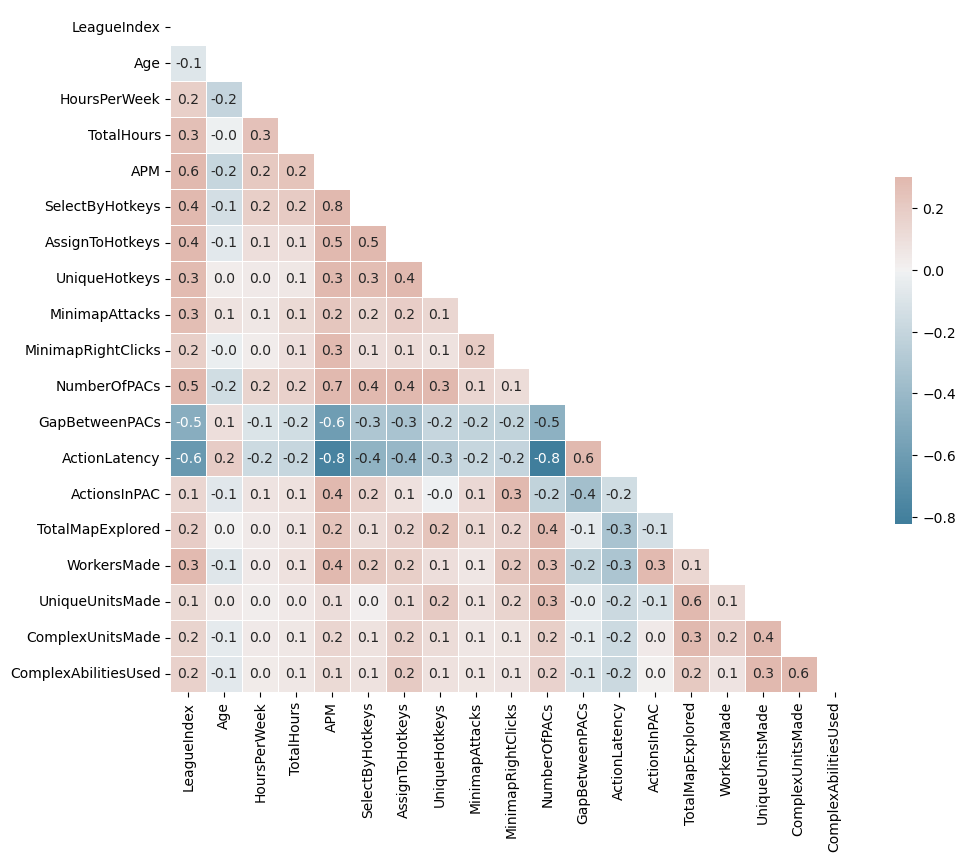

In [289]:
corr = data.corr()

f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f")

It seems that some values are quite closely correlated, but not close enough to remove them. 

No strict linear combinations are identified, and I think that ***ActionLatency*** and ***GapBetweenPACs*** will be the best predictor.

Other than that, ***NumberOfPACs*** and ***APM*** looks good.

# Splitting Training & Test Sets

In [290]:
y = data['LeagueIndex'].values
X = data.drop('LeagueIndex', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

print(len(X_train))
print(len(X_test))

1833
904


There are total **1833** training sets and **904** test sets. Now, let's fit a model.

# Model Selection & Evaluation

In [316]:
RF = RandomForestClassifier()
RF = RF.fit(X_train, y_train)

y_hat = RF.predict(X_test)
report = classification_report(y_test, y_hat, zero_division=1)

print(report)

              precision    recall  f1-score   support

           1       0.50      0.15      0.23        47
           2       0.31      0.29      0.30       102
           3       0.29      0.26      0.27       157
           4       0.35      0.48      0.41       230
           5       0.36      0.36      0.36       225
           6       0.52      0.45      0.48       139
           7       1.00      0.00      0.00         4

    accuracy                           0.37       904
   macro avg       0.48      0.28      0.29       904
weighted avg       0.38      0.37      0.36       904



Fitting a RF classifier with default parameters still shows some good results, since there's seven categories.

Since the classified response variables are continuous numerical variables, I will use **MAE (Mean Absolute Error)** as the paramter of accuracy, instead of strictly comparing and summing the results.

In [317]:
mae = mean_absolute_error(y_test, y_hat)

print(mae)

0.7887168141592921


Since the mae is about 0.78, I can say that my current model will go off by **0.78 units at average** at guessing a player's rank based on other stats.

Since the model is not optimized yet, I will run GridSearchCV and look for some better set of parameters.

In [293]:
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [2, 5, 10],
              'min_samples_split': [2, 5, 10]}

grid = GridSearchCV(RF, param_grid=param_grid)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_estimator_)

0.39932996828516554
RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50)


In [307]:
RF = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50)
RF = RF.fit(X_train, y_train)

y_hat = RF.predict(X_test)
report = classification_report(y_test, y_hat, zero_division=1)

print(report)

              precision    recall  f1-score   support

           1       0.42      0.11      0.17        47
           2       0.32      0.25      0.28       102
           3       0.35      0.36      0.35       157
           4       0.36      0.48      0.41       230
           5       0.42      0.40      0.41       225
           6       0.54      0.53      0.54       139
           7       1.00      0.00      0.00         4

    accuracy                           0.40       904
   macro avg       0.49      0.30      0.31       904
weighted avg       0.40      0.40      0.39       904



In [310]:
mae = mean_absolute_error(y_test, y_hat)

print(mae)

0.7621681415929203


The error decreased by a small fraction to **0.76,** just a little bit better than the original model.

Now, let's take a look at the confusion matrix.

[Text(0.5, 23.52222222222222, 'predicted values - 1'),
 Text(50.722222222222214, 0.5, 'true values - 1')]

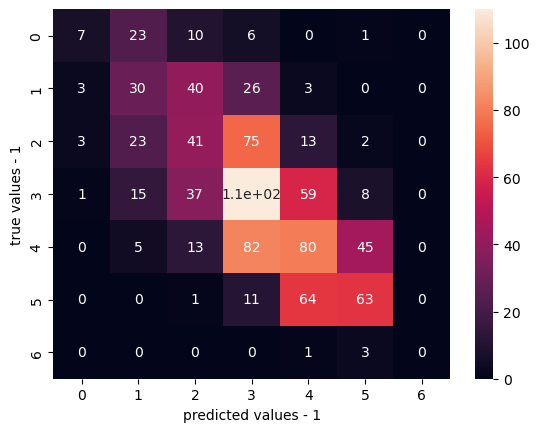

In [341]:
cf_matrix = confusion_matrix(y_test, y_hat)

cf = sns.heatmap(cf_matrix, annot=True)
cf.set(xlabel='predicted values - 1', ylabel='true values - 1')

By examining the confusion matrix, I could find out that the model had an especially hard time **differentiating players at rank 3 and 4.**

The variance of prediction values was quite high at the lower ranks, but as the true rank values went up, the variance of the predictions decreased.

To explain this, there's one important thing about the ranks and player stats : **the ranks will never strictly and linearly represent a player's skills.** 

There could still be skilled players staying on the lower ranks, and even high-ranked player may suffer from a temporary bad physical / mental state.

There are always some variances introduced to the stats due to human nature, so less competitive the league is, the higher the variance becomes.

# Demo

In [373]:
sample_data_1 = data.sample(1)
sample_data_2 = data.sample(1)
sample_data_3 = data.sample(1)
sample_data_4 = data.sample(1)
sample_data_5 = data.sample(1)

In [374]:
result_1 = RF.predict(sample_data_1.drop('LeagueIndex', axis=1))
if (result_1 == sample_data_1['LeagueIndex'].values):
    print("Correct!", result_1)
else:
    print('Wrong...', result_1, sample_data_1['LeagueIndex'].values)

Correct! [6]


In [375]:
result_2 = RF.predict(sample_data_2.drop('LeagueIndex', axis=1))
if (result_2 == sample_data_2['LeagueIndex'].values):
    print("Correct!", result_2)
else:
    print('Wrong...', result_2, sample_data_2['LeagueIndex'].values)

Correct! [5]


In [376]:
result_3 = RF.predict(sample_data_3.drop('LeagueIndex', axis=1))
if (result_3 == sample_data_3['LeagueIndex'].values):
    print("Correct!", result_3)
else:
    print('Wrong...', result_3, sample_data_3['LeagueIndex'].values)

Correct! [6]


In [377]:
result_4 = RF.predict(sample_data_4.drop('LeagueIndex', axis=1))
if (result_4 == sample_data_4['LeagueIndex'].values):
    print("Correct!", result_4)
else:
    print('Wrong...', result_4, sample_data_4['LeagueIndex'].values)

Wrong... [6] [5]


In [378]:
result_5 = RF.predict(sample_data_5.drop('LeagueIndex', axis=1))
if (result_5 == sample_data_5['LeagueIndex'].values):
    print("Correct!", result_5)
else:
    print('Wrong...', result_5, sample_data_5['LeagueIndex'].values)

Correct! [6]
